# Project: Protein stability prediction

In the project you will try to predict protein stability changes upon point mutations. 
We will use acuumulated data from experimental databases, i.e. the Megascale dataset. The other notebooks contain a more detailed description. 

Here we compute a simple baseline with the BLOSUM substitution matrix.

# Imports

In [54]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

## Dataloading

We are using the Megascale dataset. The train, validation and test sets are already predefined.
The use of the dataloaders is explained in more detail in the other notebooks.

In [41]:
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    for i, aa in enumerate(sequence):
        # set the column corresponding to the amino acid to 1
        one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence
        seq = mut_row["wt_seq"][0]

        # create mask and target tensors
        mask = torch.zeros((1, len(seq),20)) # will be 1 where we have a measurement
        target = torch.zeros((1, len(seq),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(seq)):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
        return {"sequence": seq, "mask": mask, "labels": target}

In [42]:
dataset_test = SequenceData('project_data/mega_test.csv')
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [48]:
# naive benchmark
# just use BLOSUM62 matrix to approximate ddG changes
from Bio.Align import substitution_matrices
substitution_matrix = substitution_matrices.load('BLOSUM62')

# helper functionality
# recompute the matrix to match our alphabet order
blosum_dict = {}
for wt_aa in aa_alphabet:
    blosum_dict[wt_aa] = torch.tensor([substitution_matrix[wt_aa,mut_aa] for mut_aa in aa_alphabet])

#print(blosum_dict)

class BlosumBaseline():
    # baseline model (not using pytorch bc it's not a deep learning model)
    def forward(self,sequence):
        
        prediction = torch.zeros((1,len(sequence),20))

        for i, aa in enumerate(sequence): # for each position in the sequence  
            # get BLOSUM substitution scores
            prediction[0,i] = blosum_dict[aa]

        return prediction


## Testing

To get a good feeling of how the model is performing and to compare with literature, compute the Pearson and Spearman correlations and the RMSE (root mean square error).

RMSE: 3.2742753
Pearson r: PearsonRResult(statistic=0.18838211481025818, pvalue=2.3755403984370897e-223)
Spearman r: SignificanceResult(statistic=0.15949703103250312, pvalue=7.030022891029586e-160)


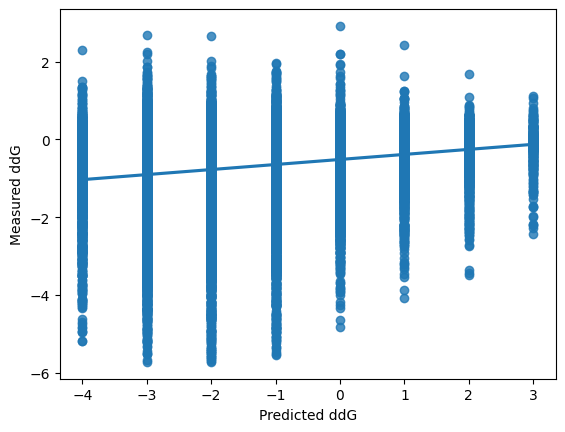

In [67]:
model = BlosumBaseline()

preds =[]
all_y = []

for batch in dataloader_test:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = model.forward(x)
    preds.append(prediction[mask==1].flatten().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared="False"))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))